In [1]:
import pandas as pd

In [2]:
data = pd.read_csv(r'C:\Users\pc\Desktop\school_deep_notes\machine learning\Untitled Folder\clean_data.csv')

In [3]:
# categories like brand and model actually have an order BMW > Dacia but again year of release and model play a role
# in the pricing of these used cars
# TargetEncoder :
# this version is where we keep brand and model seperated (test shown that merging isnt that impactful sometimes even worse)

import joblib
import pandas as pd
import numpy as np
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder


# copy and reset index
data_te = data.copy().reset_index(drop=True)
numerical_cols = ['door_number', 'fiscal_horsepower_num', 'kilometrage_num', 'year']
# normalizing numeric columns
scaler = StandardScaler()
scaled_data_te = scaler.fit_transform(data_te[numerical_cols])
scaled_df_te = pd.DataFrame(scaled_data_te, columns=[f'scaled_{col}' for col in numerical_cols])

# Save the fitted scaler
joblib.dump(scaler, "scaler.pkl")

# one-hot encoding the remaining categories
onehot_cols_te = [
    'transmission',  # 2 : Automatic Manual
    'fuel_type',     # 5
    'origin',        # 4
    'first_owner',   # 2
    'condition',     # 7
]
encoder = OneHotEncoder(handle_unknown='ignore')
encoded_data_te = encoder.fit_transform(data_te[onehot_cols_te])
encoded_df_te = pd.DataFrame(encoded_data_te.toarray(), columns=encoder.get_feature_names_out(onehot_cols_te))

# Save the fitted encoder
joblib.dump(encoder, "onehot_encoder.pkl")

# boolean feature conversion to 1 and 0
bool_cols = [
    'abs', 'airbags', 'electric_windows', 'remote_central_locking',
    'parking_sensors', 'navigation_system/gps', 'rear_view_camera',
    'speed_limiter', 'alloy_wheels', 'esp', 'air_conditioning',
    'cd/mp3/bluetooth', 'leather_seats', 'on_board_computer',
    'sunroof', 'cruise_control'
]

bool_df_te = data_te[bool_cols].astype(int)

In [13]:
bool_df_te.columns

Index(['abs', 'airbags', 'electric_windows', 'remote_central_locking',
       'parking_sensors', 'navigation_system/gps', 'rear_view_camera',
       'speed_limiter', 'alloy_wheels', 'esp', 'air_conditioning',
       'cd/mp3/bluetooth', 'leather_seats', 'on_board_computer', 'sunroof',
       'cruise_control'],
      dtype='object')

In [4]:
# Reuse previous KFold (5-split)
target_encode_cols = ['brand', 'model']

kf = KFold(n_splits=5, shuffle=True, random_state=42)
encoded_kfold_df_te_5 = pd.DataFrame(index=data_te.index)

for col in target_encode_cols:
    encoded_col = pd.Series(index=data_te.index, dtype='float64')
    for train_idx, val_idx in kf.split(data_te):
        encoder = TargetEncoder(cols=[col])
        encoder.fit(data_te.loc[train_idx, col], data_te.loc[train_idx, 'log_price'])
        encoded_col.iloc[val_idx] = encoder.transform(data_te.loc[val_idx, col])[col].values
    encoded_kfold_df_te_5[f'{col}_kfold5_te'] = encoded_col.fillna(data_te['log_price'].mean())

# Smoothed Target Encoding again
encoder_smoothed = TargetEncoder(cols=target_encode_cols, smoothing=10)
encoded_smoothed_df = encoder_smoothed.fit_transform(data_te[target_encode_cols],
                                                     data_te['log_price'])
encoded_smoothed_df.columns = [f'{col}_smoothed_te' for col in target_encode_cols]

# Final DataFrame with both smoothed and kfold (5-fold)
final_df_smoothed_kfold5 = pd.concat([scaled_df_te, bool_df_te, encoded_df_te,
                                      encoded_smoothed_df, encoded_kfold_df_te_5], axis=1)
print("✅ Final encoded shape:", final_df_smoothed_kfold5.shape)

# ========== 🔐 Save Encodings for Deployment ==========
import json

# Save smoothed encoder mappings
brand_smoothed_map = dict(zip(data_te['brand'], encoded_smoothed_df['brand_smoothed_te']))
model_smoothed_map = dict(zip(data_te['model'], encoded_smoothed_df['model_smoothed_te']))

# Save KFold-encoded results
brand_kfold_map = dict(zip(data_te['brand'], encoded_kfold_df_te_5['brand_kfold5_te']))
model_kfold_map = dict(zip(data_te['model'], encoded_kfold_df_te_5['model_kfold5_te']))

# Save to JSON files
with open("brand_smoothed_encoder.json", "w") as f:
    json.dump(brand_smoothed_map, f)
with open("model_smoothed_encoder.json", "w") as f:
    json.dump(model_smoothed_map, f)
with open("brand_encoder.json", "w") as f:
    json.dump(brand_kfold_map, f)
with open("model_encoder.json", "w") as f:
    json.dump(model_kfold_map, f)

# Save global mean (to handle unknown categories)
global_mean = float(data_te['log_price'].mean())
with open("mean_log_price.json", "w") as f:
    json.dump(global_mean, f)

    
    
# ✅ Logging preview
print("\n📦 Sample saved brand_kfold_map:", list(brand_kfold_map.items())[:3])
print("📦 Sample saved model_smoothed_map:", list(model_smoothed_map.items())[:3])
print("📦 Global log_price mean:", global_mean)

✅ Final encoded shape: (21688, 44)

📦 Sample saved brand_kfold_map: [('Rover', 11.053801570862632), ('Hyundai', 11.848660997542344), ('Chery', 10.531277610831236)]
📦 Sample saved model_smoothed_map: [('75', 11.441636502152082), ('Serie 400', 11.239388225779107), ('Serie 600', 11.46801798288237)]
📦 Global log_price mean: 11.684613840851473


In [12]:
final_df_smoothed_kfold5.columns

Index(['scaled_door_number', 'scaled_fiscal_horsepower_num',
       'scaled_kilometrage_num', 'scaled_year', 'abs', 'airbags',
       'electric_windows', 'remote_central_locking', 'parking_sensors',
       'navigation_system/gps', 'rear_view_camera', 'speed_limiter',
       'alloy_wheels', 'esp', 'air_conditioning', 'cd/mp3/bluetooth',
       'leather_seats', 'on_board_computer', 'sunroof', 'cruise_control',
       'transmission_Automatique', 'transmission_Manuelle', 'fuel_type_Diesel',
       'fuel_type_Electrique', 'fuel_type_Essence', 'fuel_type_Hybride',
       'fuel_type_LPG', 'origin_Dedouanee', 'origin_Importee neuve',
       'origin_Pas encore dedouanee', 'origin_WW au Maroc', 'first_owner_Non',
       'first_owner_Oui', 'condition_Bon', 'condition_Correct',
       'condition_Endommage', 'condition_Excellent', 'condition_Neuf',
       'condition_Pour Pieces', 'condition_Tres bon', 'brand_smoothed_te',
       'model_smoothed_te', 'brand_kfold5_te', 'model_kfold5_te'],
      dtyp

In [8]:
import catboost

In [9]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance



#  target variable
y = data_te['log_price']


feature_sets = {
    'Smoothed_KFold5': final_df_smoothed_kfold5,
}

# we will use multiple models to test
models = {
    'CatBoost': CatBoostRegressor(
        iterations=1500,     # more trees
        learning_rate=0.03,  # slower learning
        depth=8,             # slightly deeper trees
        l2_leaf_reg=5,       # regularization
        verbose=0,
        random_state=42
        ),

    'HistGBR': HistGradientBoostingRegressor(
        learning_rate=0.05,
        max_iter=1500,
        max_leaf_nodes=31,
        min_samples_leaf=20,
        l2_regularization=0.1,
        random_state=42
        ),
    #fin add new

    'RandomForest': RandomForestRegressor(
            n_estimators=500,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt',
            random_state=42,
            n_jobs=-1
        ),
    # 'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    'XGBoost': xgb.XGBRegressor(
        n_estimators=2000,
        learning_rate=0.01,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,       # L1 regularization
        reg_lambda=1.0,      # L2 regularization
        random_state=42,
        verbosity=0
        ),
    'LightGBM': lgb.LGBMRegressor(
        n_estimators=2000,
        learning_rate=0.01,
        max_depth=10,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
        ),
     'LGBM_depth12': lgb.LGBMRegressor(
        n_estimators=2000,
        learning_rate=0.01,
        max_depth=12,  # Deeper trees
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ),'ExtraTrees': ExtraTreesRegressor(
        n_estimators=500,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    ),

    'GradientBoosting': GradientBoostingRegressor(
        n_estimators=1500,
        learning_rate=0.05,
        max_depth=8,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    ),

    'SVR': SVR(
        C=100,         # Regularization parameter
        epsilon=0.1,   # Epsilon parameter for margin
        kernel='rbf',  # Radial basis function kernel
    ),

    'KNN': KNeighborsRegressor(
        n_neighbors=5,
        weights='uniform',  # All neighbors have equal weight
        algorithm='auto',
        n_jobs=-1
    ),

    'MLP': MLPRegressor(
        hidden_layer_sizes=(100,),  # Single hidden layer with 100 neurons
        activation='relu',          # ReLU activation function
        solver='adam',              # Optimizer
        max_iter=2000,
        random_state=42
    ),

}

# Storing the results here
results = []

# we lop over feature sets and models
for fs_name, X in feature_sets.items():
    # 80% train 20% test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)

        results.append({
            'Encoding': fs_name,
            'Model': model_name,
            'R2': round(r2, 4),
            'MSE': round(mse, 4),
            'RMSE': round(rmse, 4),
            'MAE': round(mae, 4)
        })
        # Print top 5 feature importances for tree-based models
        if model_name in  ['RandomForest', 'XGBoost', 'LightGBM', 'CatBoost', 'HistGBR', 'ExtraTrees', 'GradientBoosting']:
            try:
                importances = model.feature_importances_
                top_features = pd.Series(importances, index=X.columns).sort_values(ascending=False).head(5)
                print(f"\n Top 5 features for {model_name} using {fs_name} encoding:\n{top_features}\n")
            except:
                print(f"\n Could not extract feature importances for {model_name}.\n")

# Convert to DataFrame
results_df = pd.DataFrame(results)
print("All model evaluations:\n")
print(results_df.sort_values(by='R2', ascending=False).to_string(index=False))



 Top 5 features for CatBoost using Smoothed_KFold5 encoding:
scaled_year                     37.029940
model_smoothed_te               14.124603
model_kfold5_te                  8.693496
scaled_fiscal_horsepower_num     6.728431
brand_smoothed_te                6.325634
dtype: float64


 Could not extract feature importances for HistGBR.


 Top 5 features for RandomForest using Smoothed_KFold5 encoding:
scaled_year                 0.250286
model_smoothed_te           0.157510
model_kfold5_te             0.136641
transmission_Automatique    0.074762
transmission_Manuelle       0.070129
dtype: float64


 Top 5 features for XGBoost using Smoothed_KFold5 encoding:
transmission_Automatique    0.210774
transmission_Manuelle       0.169794
scaled_year                 0.160402
model_smoothed_te           0.081419
fuel_type_Essence           0.042686
dtype: float32

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-th


 Processing CatBoost...
Training CatBoost...
0:	learn: 0.5851913	total: 43.6ms	remaining: 1m 27s
100:	learn: 0.2054476	total: 964ms	remaining: 18.1s
200:	learn: 0.1874688	total: 1.82s	remaining: 16.3s
300:	learn: 0.1752956	total: 2.66s	remaining: 15s
400:	learn: 0.1675051	total: 3.54s	remaining: 14.1s
500:	learn: 0.1618818	total: 4.37s	remaining: 13.1s
600:	learn: 0.1564777	total: 5.22s	remaining: 12.2s
700:	learn: 0.1522569	total: 6.16s	remaining: 11.4s
800:	learn: 0.1486971	total: 7.14s	remaining: 10.7s
900:	learn: 0.1453813	total: 8.01s	remaining: 9.77s
1000:	learn: 0.1423347	total: 8.85s	remaining: 8.83s
1100:	learn: 0.1395076	total: 9.67s	remaining: 7.9s
1200:	learn: 0.1369920	total: 10.3s	remaining: 6.86s
1300:	learn: 0.1346788	total: 11.1s	remaining: 5.94s
1400:	learn: 0.1324531	total: 11.7s	remaining: 5.02s
1500:	learn: 0.1304879	total: 12.5s	remaining: 4.15s
1600:	learn: 0.1284390	total: 13.3s	remaining: 3.31s
1700:	learn: 0.1265393	total: 14s	remaining: 2.45s
1800:	learn: 0.

[215]	validation_0-rmse:0.29140
[216]	validation_0-rmse:0.29067
[217]	validation_0-rmse:0.29007
[218]	validation_0-rmse:0.28935
[219]	validation_0-rmse:0.28864
[220]	validation_0-rmse:0.28795
[221]	validation_0-rmse:0.28725
[222]	validation_0-rmse:0.28656
[223]	validation_0-rmse:0.28586
[224]	validation_0-rmse:0.28517
[225]	validation_0-rmse:0.28454
[226]	validation_0-rmse:0.28384
[227]	validation_0-rmse:0.28315
[228]	validation_0-rmse:0.28249
[229]	validation_0-rmse:0.28194
[230]	validation_0-rmse:0.28127
[231]	validation_0-rmse:0.28060
[232]	validation_0-rmse:0.27994
[233]	validation_0-rmse:0.27928
[234]	validation_0-rmse:0.27863
[235]	validation_0-rmse:0.27798
[236]	validation_0-rmse:0.27733
[237]	validation_0-rmse:0.27669
[238]	validation_0-rmse:0.27604
[239]	validation_0-rmse:0.27541
[240]	validation_0-rmse:0.27477
[241]	validation_0-rmse:0.27415
[242]	validation_0-rmse:0.27353
[243]	validation_0-rmse:0.27291
[244]	validation_0-rmse:0.27230
[245]	validation_0-rmse:0.27170
[246]	va

[472]	validation_0-rmse:0.20372
[473]	validation_0-rmse:0.20358
[474]	validation_0-rmse:0.20347
[475]	validation_0-rmse:0.20334
[476]	validation_0-rmse:0.20321
[477]	validation_0-rmse:0.20308
[478]	validation_0-rmse:0.20295
[479]	validation_0-rmse:0.20283
[480]	validation_0-rmse:0.20272
[481]	validation_0-rmse:0.20259
[482]	validation_0-rmse:0.20246
[483]	validation_0-rmse:0.20235
[484]	validation_0-rmse:0.20223
[485]	validation_0-rmse:0.20211
[486]	validation_0-rmse:0.20200
[487]	validation_0-rmse:0.20188
[488]	validation_0-rmse:0.20174
[489]	validation_0-rmse:0.20162
[490]	validation_0-rmse:0.20150
[491]	validation_0-rmse:0.20138
[492]	validation_0-rmse:0.20128
[493]	validation_0-rmse:0.20117
[494]	validation_0-rmse:0.20106
[495]	validation_0-rmse:0.20095
[496]	validation_0-rmse:0.20083
[497]	validation_0-rmse:0.20072
[498]	validation_0-rmse:0.20059
[499]	validation_0-rmse:0.20050
[500]	validation_0-rmse:0.20038
[501]	validation_0-rmse:0.20027
[502]	validation_0-rmse:0.20020
[503]	va

[729]	validation_0-rmse:0.18626
[730]	validation_0-rmse:0.18623
[731]	validation_0-rmse:0.18620
[732]	validation_0-rmse:0.18616
[733]	validation_0-rmse:0.18612
[734]	validation_0-rmse:0.18608
[735]	validation_0-rmse:0.18605
[736]	validation_0-rmse:0.18601
[737]	validation_0-rmse:0.18597
[738]	validation_0-rmse:0.18594
[739]	validation_0-rmse:0.18591
[740]	validation_0-rmse:0.18587
[741]	validation_0-rmse:0.18585
[742]	validation_0-rmse:0.18583
[743]	validation_0-rmse:0.18580
[744]	validation_0-rmse:0.18576
[745]	validation_0-rmse:0.18574
[746]	validation_0-rmse:0.18570
[747]	validation_0-rmse:0.18567
[748]	validation_0-rmse:0.18565
[749]	validation_0-rmse:0.18561
[750]	validation_0-rmse:0.18559
[751]	validation_0-rmse:0.18556
[752]	validation_0-rmse:0.18554
[753]	validation_0-rmse:0.18550
[754]	validation_0-rmse:0.18548
[755]	validation_0-rmse:0.18545
[756]	validation_0-rmse:0.18542
[757]	validation_0-rmse:0.18539
[758]	validation_0-rmse:0.18536
[759]	validation_0-rmse:0.18534
[760]	va

[986]	validation_0-rmse:0.18048
[987]	validation_0-rmse:0.18046
[988]	validation_0-rmse:0.18044
[989]	validation_0-rmse:0.18044
[990]	validation_0-rmse:0.18043
[991]	validation_0-rmse:0.18041
[992]	validation_0-rmse:0.18041
[993]	validation_0-rmse:0.18040
[994]	validation_0-rmse:0.18038
[995]	validation_0-rmse:0.18036
[996]	validation_0-rmse:0.18034
[997]	validation_0-rmse:0.18032
[998]	validation_0-rmse:0.18031
[999]	validation_0-rmse:0.18030
[1000]	validation_0-rmse:0.18029
[1001]	validation_0-rmse:0.18027
[1002]	validation_0-rmse:0.18026
[1003]	validation_0-rmse:0.18024
[1004]	validation_0-rmse:0.18021
[1005]	validation_0-rmse:0.18020
[1006]	validation_0-rmse:0.18018
[1007]	validation_0-rmse:0.18017
[1008]	validation_0-rmse:0.18015
[1009]	validation_0-rmse:0.18014
[1010]	validation_0-rmse:0.18012
[1011]	validation_0-rmse:0.18011
[1012]	validation_0-rmse:0.18009
[1013]	validation_0-rmse:0.18008
[1014]	validation_0-rmse:0.18006
[1015]	validation_0-rmse:0.18004
[1016]	validation_0-rmse

[1235]	validation_0-rmse:0.17759
[1236]	validation_0-rmse:0.17758
[1237]	validation_0-rmse:0.17758
[1238]	validation_0-rmse:0.17756
[1239]	validation_0-rmse:0.17755
[1240]	validation_0-rmse:0.17755
[1241]	validation_0-rmse:0.17754
[1242]	validation_0-rmse:0.17753
[1243]	validation_0-rmse:0.17752
[1244]	validation_0-rmse:0.17752
[1245]	validation_0-rmse:0.17751
[1246]	validation_0-rmse:0.17750
[1247]	validation_0-rmse:0.17750
[1248]	validation_0-rmse:0.17749
[1249]	validation_0-rmse:0.17749
[1250]	validation_0-rmse:0.17748
[1251]	validation_0-rmse:0.17747
[1252]	validation_0-rmse:0.17746
[1253]	validation_0-rmse:0.17746
[1254]	validation_0-rmse:0.17744
[1255]	validation_0-rmse:0.17743
[1256]	validation_0-rmse:0.17743
[1257]	validation_0-rmse:0.17743
[1258]	validation_0-rmse:0.17742
[1259]	validation_0-rmse:0.17741
[1260]	validation_0-rmse:0.17740
[1261]	validation_0-rmse:0.17740
[1262]	validation_0-rmse:0.17740
[1263]	validation_0-rmse:0.17739
[1264]	validation_0-rmse:0.17738
[1265]	val

[1484]	validation_0-rmse:0.17577
[1485]	validation_0-rmse:0.17576
[1486]	validation_0-rmse:0.17576
[1487]	validation_0-rmse:0.17575
[1488]	validation_0-rmse:0.17575
[1489]	validation_0-rmse:0.17574
[1490]	validation_0-rmse:0.17574
[1491]	validation_0-rmse:0.17573
[1492]	validation_0-rmse:0.17572
[1493]	validation_0-rmse:0.17572
[1494]	validation_0-rmse:0.17571
[1495]	validation_0-rmse:0.17571
[1496]	validation_0-rmse:0.17571
[1497]	validation_0-rmse:0.17571
[1498]	validation_0-rmse:0.17571
[1499]	validation_0-rmse:0.17570
[1500]	validation_0-rmse:0.17569
[1501]	validation_0-rmse:0.17568
[1502]	validation_0-rmse:0.17568
[1503]	validation_0-rmse:0.17568
[1504]	validation_0-rmse:0.17567
[1505]	validation_0-rmse:0.17566
[1506]	validation_0-rmse:0.17566
[1507]	validation_0-rmse:0.17565
[1508]	validation_0-rmse:0.17565
[1509]	validation_0-rmse:0.17564
[1510]	validation_0-rmse:0.17564
[1511]	validation_0-rmse:0.17563
[1512]	validation_0-rmse:0.17562
[1513]	validation_0-rmse:0.17562
[1514]	val

[1733]	validation_0-rmse:0.17439
[1734]	validation_0-rmse:0.17439
[1735]	validation_0-rmse:0.17438
[1736]	validation_0-rmse:0.17438
[1737]	validation_0-rmse:0.17437
[1738]	validation_0-rmse:0.17437
[1739]	validation_0-rmse:0.17437
[1740]	validation_0-rmse:0.17436
[1741]	validation_0-rmse:0.17436
[1742]	validation_0-rmse:0.17436
[1743]	validation_0-rmse:0.17436
[1744]	validation_0-rmse:0.17435
[1745]	validation_0-rmse:0.17435
[1746]	validation_0-rmse:0.17435
[1747]	validation_0-rmse:0.17434
[1748]	validation_0-rmse:0.17434
[1749]	validation_0-rmse:0.17433
[1750]	validation_0-rmse:0.17433
[1751]	validation_0-rmse:0.17433
[1752]	validation_0-rmse:0.17432
[1753]	validation_0-rmse:0.17432
[1754]	validation_0-rmse:0.17431
[1755]	validation_0-rmse:0.17431
[1756]	validation_0-rmse:0.17430
[1757]	validation_0-rmse:0.17431
[1758]	validation_0-rmse:0.17430
[1759]	validation_0-rmse:0.17430
[1760]	validation_0-rmse:0.17430
[1761]	validation_0-rmse:0.17430
[1762]	validation_0-rmse:0.17429
[1763]	val

[1982]	validation_0-rmse:0.17341
[1983]	validation_0-rmse:0.17341
[1984]	validation_0-rmse:0.17340
[1985]	validation_0-rmse:0.17340
[1986]	validation_0-rmse:0.17339
[1987]	validation_0-rmse:0.17339
[1988]	validation_0-rmse:0.17338
[1989]	validation_0-rmse:0.17338
[1990]	validation_0-rmse:0.17337
[1991]	validation_0-rmse:0.17337
[1992]	validation_0-rmse:0.17337
[1993]	validation_0-rmse:0.17336
[1994]	validation_0-rmse:0.17336
[1995]	validation_0-rmse:0.17336
[1996]	validation_0-rmse:0.17335
[1997]	validation_0-rmse:0.17335
[1998]	validation_0-rmse:0.17335
[1999]	validation_0-rmse:0.17335
XGBoost Results: R2=0.9203, RMSE=0.1746, MAE=0.1154
Top 5 features for XGBoost:
scaled_year          0.301459
transmission_te      0.248712
model_smoothed_te    0.119152
fuel_type_Essence    0.068608
fuel_type_Diesel     0.039893
dtype: float32


 Processing HistGBR...
Training HistGBR...
HistGBR Results: R2=0.9197, RMSE=0.1752, MAE=0.1146
Permutation importance for HistGBR:
scaled_year          0.75523

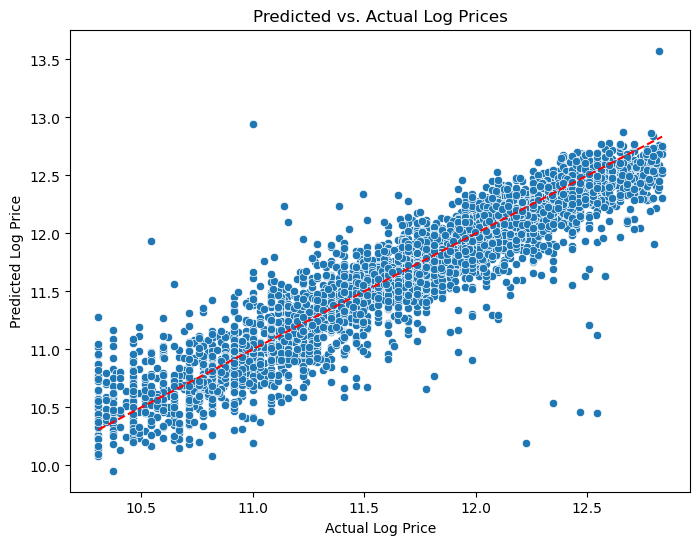

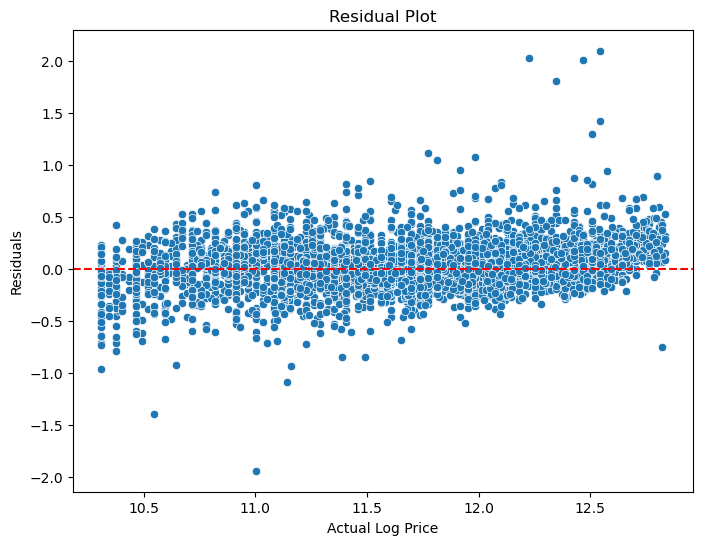

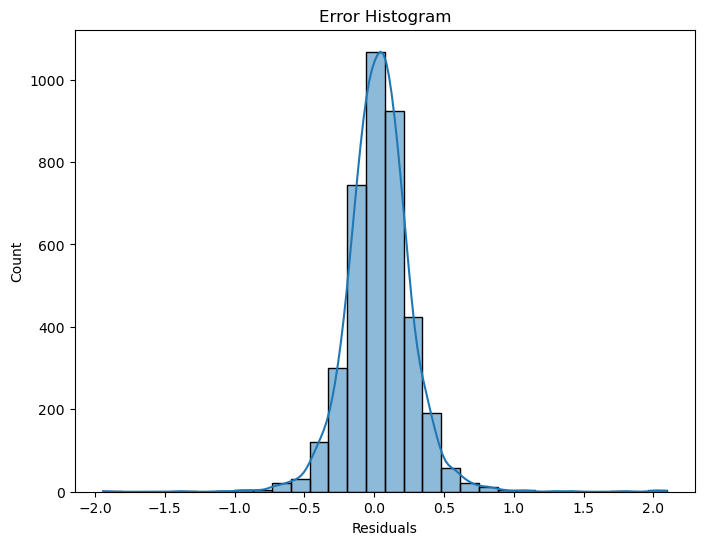


📋 Test Samples:
  actual_price  predicted_price
      38001.0     32651.396094
     196001.0    200613.613443
      32001.0     50671.579751
     119001.0    113120.088741
      67001.0     56478.324491

 Performing 5-fold cross-validation for CatBoost...
0:	learn: 0.5995206	total: 37ms	remaining: 1m 14s
100:	learn: 0.2083762	total: 990ms	remaining: 18.6s
200:	learn: 0.1907144	total: 2.04s	remaining: 18.3s
300:	learn: 0.1796364	total: 3.42s	remaining: 19.3s
400:	learn: 0.1722692	total: 4.38s	remaining: 17.5s
500:	learn: 0.1665379	total: 5.21s	remaining: 15.6s
600:	learn: 0.1620824	total: 5.87s	remaining: 13.7s
700:	learn: 0.1579927	total: 6.48s	remaining: 12s
800:	learn: 0.1542582	total: 7.42s	remaining: 11.1s
900:	learn: 0.1512688	total: 8.32s	remaining: 10.2s
1000:	learn: 0.1482747	total: 9.27s	remaining: 9.26s
1100:	learn: 0.1455973	total: 10.2s	remaining: 8.34s
1200:	learn: 0.1432204	total: 11.3s	remaining: 7.51s
1300:	learn: 0.1410369	total: 12.5s	remaining: 6.74s
1400:	learn: 0.

In [11]:
# version 1 : 
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance
from category_encoders import TargetEncoder
import joblib
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import json
import matplotlib.pyplot as plt
import seaborn as sns



# Target variable
y = data_te['log_price']

# Feature set
X = final_df_smoothed_kfold5.copy()

# changing the transmission encoding 
te = TargetEncoder(cols=['transmission'])
X['transmission_te'] = te.fit_transform(data_te['transmission'], y)
# Save the fitted encoder to use later in Streamlit
joblib.dump(te, 'transmission_target_encoder.pkl')

X = X.drop(columns=['transmission_Automatique', 'transmission_Manuelle'], errors='ignore')

# Feature engineering
X['year_kilometrage_ratio'] = X['scaled_year'] / (X['scaled_kilometrage_num'] + 1e-6)
X['model_fiscal_power'] = X['model_smoothed_te'] * X['scaled_fiscal_horsepower_num']

# Filter low-row brands and outliers
brand_counts = data_te['brand'].value_counts()
valid_brands = brand_counts[brand_counts >= 10].index
data_te_filtered = data_te[data_te['brand'].isin(valid_brands)]
q1, q3 = data_te_filtered['log_price'].quantile([0.05, 0.95])
mask = (data_te_filtered['log_price'] >= q1) & (data_te_filtered['log_price'] <= q3)
data_te_filtered = data_te_filtered[mask]
X = X.loc[data_te_filtered.index]
y = data_te_filtered['log_price']

# Models
models = {
    'CatBoost': CatBoostRegressor(iterations=2000, learning_rate=0.05, depth=6, l2_leaf_reg=5, bagging_temperature=1.0, verbose=100, random_state=42, early_stopping_rounds=50),
    'XGBoost': xgb.XGBRegressor(n_estimators=2000, learning_rate=0.005, max_depth=8, subsample=0.8, colsample_bytree=0.8, reg_alpha=1.5, reg_lambda=1.0, random_state=42, early_stopping_rounds=50, verbosity=1),
    'HistGBR': HistGradientBoostingRegressor(learning_rate=0.05, max_iter=1000, max_leaf_nodes=50, min_samples_leaf=10, l2_regularization=0.0, random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=500, max_depth=15, min_samples_split=5, min_samples_leaf=2, max_features='sqrt', random_state=42, n_jobs=2),
    'LightGBM': lgb.LGBMRegressor(n_estimators=2000, learning_rate=0.01, max_depth=10, num_leaves=31, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.5, reg_lambda=0.5, random_state=42, force_row_wise=True),
    'LGBM_depth12': lgb.LGBMRegressor(n_estimators=2000, learning_rate=0.01, max_depth=12, num_leaves=31, subsample=0.8, colsample_bytree=0.8, random_state=42, force_row_wise=True),
    'ExtraTrees': ExtraTreesRegressor(n_estimators=500, max_depth=15, min_samples_split=5, min_samples_leaf=2, max_features='sqrt', random_state=42, n_jobs=2),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=1500, learning_rate=0.05, max_depth=8, min_samples_split=5, min_samples_leaf=2, random_state=42),
    'SVR': SVR(C=100, epsilon=0.1, kernel='rbf'),
    'KNN': KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='auto', n_jobs=2),
    'MLP': MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=2000, random_state=42)
}

# Split data
#  64% Train  16% Validation 20% Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Results
results = []
best_models = {}

# Evaluation
for model_name, model in models.items():
    print(f"\n Processing {model_name}...")
    best_model = model
    best_models[model_name] = best_model
    
    # Train
    print(f"Training {model_name}...")
    if model_name == 'XGBoost':
        best_model.fit(X_train_sub, y_train_sub, eval_set=[(X_val, y_val)], verbose=True)
    else:
        best_model.fit(X_train_sub, y_train_sub)
    
    # Evaluate
    y_pred = best_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    results.append({
        'Model': model_name,
        'R2': round(r2, 4),
        'RMSE': round(rmse, 4),
        'MAE': round(mae, 4)
    })
    print(f"{model_name} Results: R2={r2:.4f}, RMSE={rmse:.4f}, MAE={mae:.4f}")

    # Feature importance
    if model_name in ['RandomForest', 'XGBoost', 'LightGBM', 'CatBoost', 'ExtraTrees', 'GradientBoosting']:
        try:
            importances = best_model.feature_importances_
            top_features = pd.Series(importances, index=X.columns).sort_values(ascending=False).head(5)
            print(f"Top 5 features for {model_name}:\n{top_features}\n")
        except:
            print(f"Could not extract feature importances for {model_name}.")
    elif model_name == 'HistGBR':
        try:
            perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=5, random_state=42)
            top_features = pd.Series(perm_importance.importances_mean, index=X.columns).sort_values(ascending=False).head(5)
            print(f"Permutation importance for {model_name}:\n{top_features}\n")
        except:
            print(f"Could not compute permutation importance for {model_name}.")

# Results
results_df = pd.DataFrame(results)
print("\n Final Results:\n")
print(results_df.sort_values(by='R2', ascending=False).to_string(index=False))



# Save best model (CatBoost since R2=0.9219)
best_model_name = results_df.loc[results_df['R2'].idxmax(), 'Model']
best_model = best_models[best_model_name]

# downloading the model
joblib.dump(best_model, 'best_model_manual.pkl')
# Save feature column order for inference
with open('feature_order.json', 'w') as f:
    json.dump(X.columns.tolist(), f)

# 1. Visualizations
print("\n Generating visualizations...")
# Scatter Plot: Predicted vs. Actual
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Log Price')
plt.ylabel('Predicted Log Price')
plt.title('Predicted vs. Actual Log Prices')
plt.show()
plt.close()


# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Log Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()
plt.close()

# Error Histogram
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel('Residuals')
plt.title('Error Histogram')
plt.show()
plt.close()


# 2. Test Samples
samples = X_test.head(5).copy()
samples['actual_log_price'] = y_test.head(5)
samples['predicted_log_price'] = y_pred[:5]
samples['actual_price'] = np.exp(samples['actual_log_price'])
samples['predicted_price'] = np.exp(samples['predicted_log_price'])
print("\n📋 Test Samples:\n", samples[['actual_price', 'predicted_price']].to_string(index=False))


# 7. Overfitting Check with Cross-Validation
print(f"\n Performing 5-fold cross-validation for {best_model_name}...")
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='r2')
print(f"Cross-Validation R2: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

In [17]:
import sklearn
import catboost
import xgboost as xgb
import lightgbm as lgb
import category_encoders
import joblib
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns

print("scikit-learn:", sklearn.__version__)
print("catboost:", catboost.__version__)
print("xgboost:", xgb.__version__)
print("lightgbm:", lgb.__version__)
print("category_encoders:", category_encoders.__version__)
print("joblib:", joblib.__version__)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("matplotlib:", matplotlib.__version__)
print("seaborn:", sns.__version__)


scikit-learn: 1.0.2
catboost: 1.2.8
xgboost: 2.1.4
lightgbm: 4.6.0
category_encoders: 2.6.4
joblib: 1.1.0
numpy: 1.24.4
pandas: 1.4.4
matplotlib: 3.5.2
seaborn: 0.11.2
